In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Iterable, List
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

import collections
import pandas as pd 
import numpy as np
import random 
from torch.utils.data import DataLoader, random_split
import os

In [84]:
# MMD
def compute_pairwise_distances(x, y):
    '''
    ||x - y||^2 = x^2 + y^2 - 2xy
    '''
    # * .view(-1, 1) -> changee to col vector
    x_norm = (x**2).sum(1).view(-1, 1)
    y_t = y.t()
    y_norm = (y**2).sum(1).view(1, -1)
    # * torch.mm -> matrix muptilply
    # * .sum(1) -> sum by row
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    # * torch.clamp -> change input value to be between 0.0 and np.inf
    # return torch.clamp(dist, 0.0, np.inf)
    return torch.abs(dist)

def _gaussian_kernel_matrix(x, y):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sigmas = torch.FloatTensor([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100, 1e3, 1e4, 1e5, 1e6]).to(device)
    dist = compute_pairwise_distances(x, y)
    beta = 1. / (2. * sigmas.view(-1, 1))
    s = - beta.mm(dist.reshape((1, -1)) )
    result = torch.sum(torch.exp(s), dim = 0)
    return result

def maximum_mean_discrepancy(x, y): #Function to calculate MMD value
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cost_xx = torch.mean(_gaussian_kernel_matrix(x, x))
    cost_yy = torch.mean(_gaussian_kernel_matrix(y, y))
    cost_xy = 2.0 * torch.mean(_gaussian_kernel_matrix(x, y))
    cost = torch.sqrt((cost_xx + cost_yy - cost_xy) ** 2 + 1e-9)
    if cost.data.item()<0:
        cost = torch.FloatTensor([0.0]).to(device)

    return cost

In [85]:
class FC(nn.Module):
    def __init__(self, features = [1000, 500, 500], use_batch_norm = True, dropout_rate = 0.0, negative_slope = 0.0, use_bias = True):
        super(FC, self).__init__()

        self.features = features
        self.fc_layers = []

        # create fc layers according to the layers_dim
        self.fc_layers = nn.Sequential(
            collections.OrderedDict(
                [
                    (
                        "Layer {}".format(i),
                        nn.Sequential(
                            collections.OrderedDict(
                                [
                                    ("linear", nn.Linear(n_in, n_out) if use_bias else nn.Linear(n_in, n_out, bias = False),),
                                    ("batchnorm", nn.BatchNorm1d(n_out, momentum=0.01, eps=0.001) if use_batch_norm else None,),
                                    ("relu", nn.ReLU() if negative_slope <= 0 else nn.LeakyReLU(negative_slope = negative_slope),),
                                    ("dropout", nn.Dropout(p=dropout_rate) if dropout_rate > 0 else None,),
                                ]
                            )
                        ),
                    )
                    for i, (n_in, n_out) in enumerate(zip(self.features[:-1], self.features[1:]))
                ]
            )
        )

    def forward(self, x):
        # loop through all layers
        for layers in self.fc_layers:
            # loop through linear, batchnorm, relu, dropout, etc
            for layer in layers:
                if layer is not None:
                    x = layer(x)
        return x

In [86]:
a = FC(features= [1024, 512, 128, 32, 8])
a

FC(
  (fc_layers): Sequential(
    (Layer 0): Sequential(
      (linear): Linear(in_features=1024, out_features=512, bias=True)
      (batchnorm): BatchNorm1d(512, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): None
    )
    (Layer 1): Sequential(
      (linear): Linear(in_features=512, out_features=128, bias=True)
      (batchnorm): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): None
    )
    (Layer 2): Sequential(
      (linear): Linear(in_features=128, out_features=32, bias=True)
      (batchnorm): BatchNorm1d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): None
    )
    (Layer 3): Sequential(
      (linear): Linear(in_features=32, out_features=8, bias=True)
      (batchnorm): BatchNorm1d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): No

In [87]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, features = [1024, 256, 32, 8], dropout_rate = 0.1, negative_slope = 0.2):
        super(Encoder,self).__init__()
        
        self.features = features
        if len(features) > 2:
            self.fc = FC(
                features = features[:-1],
                dropout_rate = dropout_rate,
                negative_slope = negative_slope,
                use_bias = True
            )
        self.output = nn.Linear(features[-2], features[-1])

    def forward(self, x):
        if len(self.features) > 2:
            x = self.fc(x)
        x = self.output(x)
        return x

In [88]:
# Decoder
class Decoder(nn.Module):
    def __init__(self, features = [8, 32, 256, 1024], dropout_rate = 0.0, negative_slope = 0.2):
        super(Decoder, self).__init__()
        self.fc = FC(
            features = features,
            dropout_rate = dropout_rate,
            negative_slope = negative_slope,
            use_bias = True
        )

    def forward(self, z):
        # The decoder returns values for the parameters of the ZINB distribution
        x_mean = self.fc(z)
        return x_mean

In [89]:
class gene_act(nn.Module):
    def __init__(self, features = [1000, 500, 500], use_batch_norm = True, dropout_rate = 0.0, negative_slope = 0.0):
        super(gene_act, self).__init__()

        self.features = features
        self.fc_layers = []

        # create fc layers according to the layers_dim
        self.fc_layers = nn.Sequential(
            collections.OrderedDict(
                [
                    (
                        "Layer {}".format(i),
                        nn.Sequential(
                            collections.OrderedDict(
                                [
                                    ("linear", nn.Linear(n_in, n_out, bias = False),),
                                    ("batchnorm", nn.BatchNorm1d(n_out, momentum=0.01, eps=0.001) if use_batch_norm else None,),
                                    ("act", nn.ReLU() if negative_slope <= 0 else nn.LeakyReLU(negative_slope = negative_slope),),
                                    ("dropout", nn.Dropout(p=dropout_rate) if dropout_rate > 0 else None,),
                                ]
                            )
                        ),
                    )
                    for i, (n_in, n_out) in enumerate(zip(self.features[:-1], self.features[1:]))
                ]
            )
        )

    def forward(self, x):
        # loop through all layers
        for layers in self.fc_layers:
            # loop through linear, batchnorm, relu, dropout, etc
            for layer in layers:
                if layer is not None:
                    x = layer(x)
        
        return x


In [90]:
import scanpy as sc

In [91]:
path_mtx = r"D:\Francis Secrets\Pycharm Projects\xsede\dataset284\covid284_h5file\matrix_by_sample\mtx_0.mtx"
data_test = sc.read_mtx(path_mtx)
mtx_data = np.array(data_test.X.todense())
# mtx_data

In [92]:
print(mtx_data.T.shape)

(27943, 238)


In [93]:
batch_size = 64
all_data = mtx_data
random.seed(214)
m = len(all_data[:200])
print(m)
# print([int(m - m * 0.2), int(m * 0.2)])
train_data, val_data = random_split(dataset=all_data[:200], lengths=[int(m - m * 0.2), int(m * 0.2)])
# train_data, val_data = all_data[:150], all_data[151:200]
test_data = all_data[201:]
print((train_data.dataset.shape))
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
print(train_loader)

200
(200, 27943)


In [94]:
for i in train_loader:
    print(i.shape)
    break

torch.Size([64, 27943])


In [81]:
# data_dir = 'dataset'
# train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
# test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

# train_transform = transforms.Compose([transforms.ToTensor(),])
# test_transform = transforms.Compose([transforms.ToTensor(),])

# train_dataset.transform = train_transform
# test_dataset.transform = test_transform

# m = len(train_dataset)

# train_data, val_data = random_split(mtx_data, [int(m-m*0.2), int(m*0.2)])
# batch_size = 512

# train_loader = DataLoader(train_data, batch_size=batch_size)
# valid_loader = DataLoader(val_data, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [99]:
# encoder = Encoder(features=[train_data.shape[1], 1024, 256, 64, 16 ])

# decoder = Decoder(features=[train_data.shape[1], 1024, 256, 64, 16 ][::-1])
encoder = Encoder(features=[all_data.shape[1], 1024, 256, 64, 16])
decoder = Decoder(features=[all_data.shape[1], 1024, 256, 64, 16][::-1])
# Define loss func
class MMD_LOSS(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    def forward(self, output, target):
        loss_MSE = nn.MSELoss().forward(output, target)
        loss_MMD = maximum_mean_discrepancy(output, target)
        return loss_MMD + loss_MSE


loss_fn = torch.nn.MSELoss()

# Define Optimizer
lr = 0.001

#Random seed
torch.manual_seed(0)
param_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(param_to_optimize, lr=lr, weight_decay=1e-05)

def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [100]:
ls = MMD_LOSS()
# ls.forward()
# print(ls([1,2,3], [1,2,3]))
a = torch.zeros([2, 4])
b = torch.ones([2,4])
print(a, b)
# ls.forward(a, b)
print(ls.forward(a, b))

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]]) tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor(16.6291)


In [65]:
decoder

Decoder(
  (fc): FC(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (linear): Linear(in_features=16, out_features=64, bias=True)
        (batchnorm): BatchNorm1d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.2)
        (dropout): None
      )
      (Layer 1): Sequential(
        (linear): Linear(in_features=64, out_features=256, bias=True)
        (batchnorm): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.2)
        (dropout): None
      )
      (Layer 2): Sequential(
        (linear): Linear(in_features=256, out_features=1024, bias=True)
        (batchnorm): BatchNorm1d(1024, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.2)
        (dropout): None
      )
      (Layer 3): Sequential(
        (linear): Linear(in_features=1024, out_features=27943, bias=True)
      

In [101]:
# Training
def train_epoch(encoder, decoder, dataloader, loss_fn, optimizer, noise_factor=0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch in dataloader:
        # _
        # print(image_batch)
        image_noisy = add_noise(image_batch, noise_factor)
        # print(image_noisy.shape)
        # Encode
        # image_noisy_1 = image_noisy.view(-1, 1)
        encoded_data = encoder(image_noisy)
        # Decode
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        # Backword 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print
        print('\t partial train loss : %f' %(loss.data))
        train_loss.append(loss.detach().numpy())
        return np.mean(train_loss)

In [105]:
# Testing func
def test_epoch(encoder, decoder, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # Don't track gradients
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            image_noisy = add_noise(image_batch, noise_factor)
            # Encode
            encoded_data = encoder(image_noisy)
            # Decode
            decoded_data = decoder(encoded_data)
            # Append the output list to the original image
            conc_out.append(decoded_data)
            conc_label.append(image_batch)
            # Create single tensor with all values
            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label)
            # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)
            return val_loss.data            

In [103]:
# def plot_ae_outputs(encoder,decoder,n=5):
#     plt.figure(figsize=(10,4.5))
#     for i in range(n):
#       ax = plt.subplot(2,n,i+1)
#       img = test_dataset[i][0].unsqueeze(0)
#       encoder.eval()
#       decoder.eval()
#       with torch.no_grad():
#          rec_img  = decoder(encoder(img))
#       plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
#       ax.get_xaxis().set_visible(False)
#       ax.get_yaxis().set_visible(False)  
#       if i == n//2:
#         ax.set_title('Original images')
#       ax = plt.subplot(2, n, i + 1 + n)
#       plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
#       ax.get_xaxis().set_visible(False)
#       ax.get_yaxis().set_visible(False)  
#       if i == n//2:
#          ax.set_title('Reconstructed images')
#     plt.show()

In [107]:
num_epochs = 100
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder, train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)

	 partial train loss : 0.350189

 EPOCH 1/100 	 train loss 0.3501893877983093 	 val loss 0.16649560630321503
	 partial train loss : 0.249231

 EPOCH 2/100 	 train loss 0.24923096597194672 	 val loss 0.16706979274749756
	 partial train loss : 0.192376

 EPOCH 3/100 	 train loss 0.1923755407333374 	 val loss 0.16756689548492432
	 partial train loss : 0.167297

 EPOCH 4/100 	 train loss 0.16729727387428284 	 val loss 0.1680460274219513
	 partial train loss : 0.155158

 EPOCH 5/100 	 train loss 0.15515762567520142 	 val loss 0.16850772500038147
	 partial train loss : 0.149020

 EPOCH 6/100 	 train loss 0.14901991188526154 	 val loss 0.1692381650209427
	 partial train loss : 0.144849

 EPOCH 7/100 	 train loss 0.14484873414039612 	 val loss 0.1698703020811081
	 partial train loss : 0.142631

 EPOCH 8/100 	 train loss 0.1426311880350113 	 val loss 0.17035675048828125
	 partial train loss : 0.140654

 EPOCH 9/100 	 train loss 0.14065386354923248 	 val loss 0.17146095633506775
	 partial train 

{'train_loss': [0.3501894, 0.24923097, 0.19237554, 0.16729727, 0.15515763, 0.14901991, 0.14484873, 0.14263119, 0.14065386, 0.13942668, 0.13807847, 0.13689698, 0.13610095, 0.13507926, 0.13374749, 0.13326631, 0.13281533, 0.13134432, 0.13129932, 0.13037688, 0.12977347, 0.12902755, 0.12868206, 0.12797868, 0.12745878, 0.12727575, 0.1267216, 0.12579843, 0.12549724, 0.12493442, 0.12474664, 0.12435983, 0.12361403, 0.12316246, 0.123007044, 0.122422874, 0.12220512, 0.1217172, 0.12139263, 0.12086224, 0.12062247, 0.12008834, 0.11985132, 0.11952729, 0.119145274, 0.118977256, 0.11838817, 0.11807795, 0.117576145, 0.1172686, 0.11729575, 0.11736542, 0.116540834, 0.11619243, 0.11603162, 0.11554, 0.11527678, 0.1149944, 0.1147902, 0.114473626, 0.1143151, 0.113895185, 0.11365462, 0.11346311, 0.113219015, 0.1127968, 0.112504296, 0.11246866, 0.112210035, 0.11194058, 0.111816905, 0.11157965, 0.111099735, 0.11091486, 0.110569276, 0.11030422, 0.11024826, 0.10984445, 0.10946052, 0.10939462, 0.109097, 0.10880501,

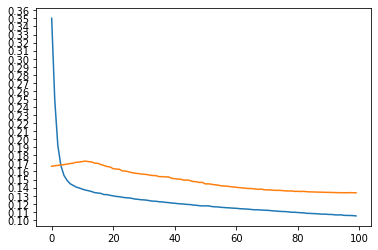

In [118]:
# PLOT
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
print(diz_loss)
x_ax = range(len(diz_loss['train_loss']))
print(x_ax)
x_tcs = np.arange(0.1, 0.5, 0.01)
# ax.set_ylim([0.1, 0.4])
plt.yticks(x_tcs)
plt.plot(x_ax, diz_loss['train_loss'])
plt.plot(x_ax, diz_loss['val_loss'])



## MMD model from Kaggle

In [134]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y):
    '''
    Using gaussian kernel for MMD
    '''
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    print(xx, xx.diag(),xx.diag().unsqueeze(0), rx)
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    # applying kernel method
    sigmas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100, 1e3, 1e4, 1e5, 1e6]
    for sigma in sigmas:
        XX += torch.exp(-0.5*dxx/sigma)
        YY += torch.exp(-0.5*dyy/sigma)
        XY += torch.exp(-0.5*dxy/sigma)

    return torch.mean(XX + YY - 2. * XY)